In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Import custom functions from 'pre_processing.py' ##
try:
    import importlib
    importlib.reload(pp)
except NameError: # It hasn't been imported yet
    import pre_processing as pp
    
fnirs_data = r'C:\Users\61407\mental-health-modelling\data\fNIRS\bandpass_filtered_whole_data'
scalogram_dir = r'C:\Users\61407\mental-health-modelling\fNIRS Mental Workload\scalograms'
pipeline1 =  r'C:\Users\61407\mental-health-modelling\fNIRS Mental Workload\trained_networks\1block_test_10s_chunks_no_overlap'
all_data = pp.upload_all_subjects(fnirs_data, scaled=True)

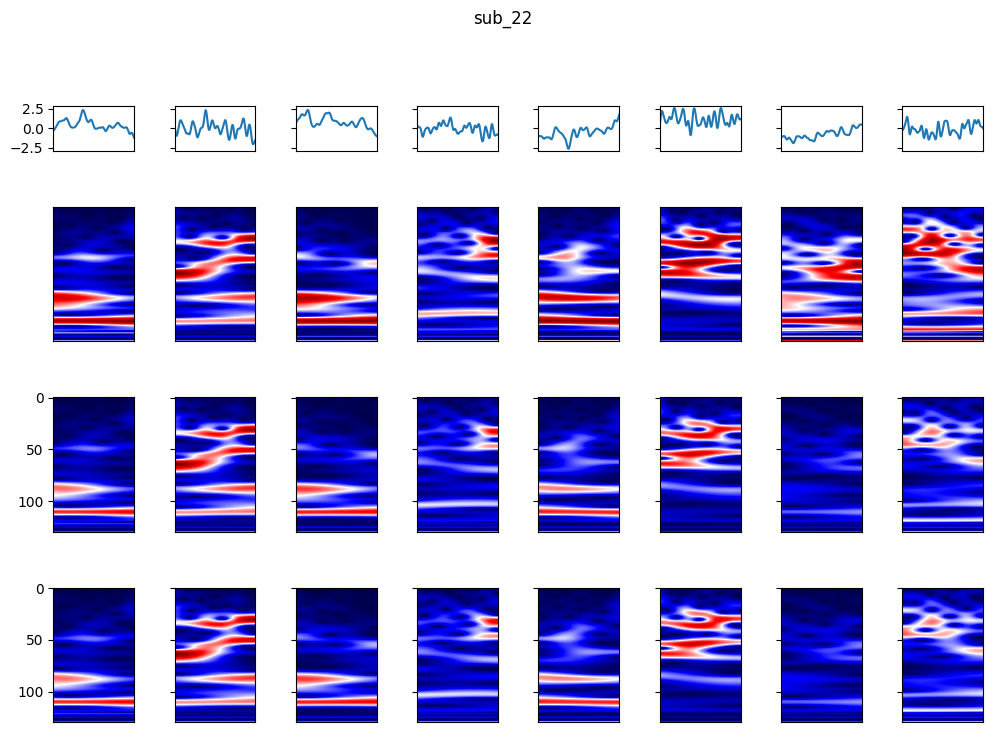

In [6]:
for f in [[x for x in os.listdir(scalogram_dir) if '.pt' in x][6]]:
    fig, ax = plt.subplots(nrows=4, ncols=8,
                           figsize=(12,8),
                           sharey='row', sharex=True,
                           gridspec_kw={'height_ratios':[0.1,0.3,0.3,0.3],
                                        'wspace':0.5,
                                        'hspace':0.5})
    sub = ('_').join(f.split('_')[:2])
    fig.suptitle(sub, fontsize=12, y=1)
    sub_data = torch.load(os.path.join(scalogram_dir, f))
    sub_traces = all_data[all_data.index.get_level_values(0) == sub]
    sub_labels = np.load(os.path.join(scalogram_dir, f'{sub}_labels.npy'), allow_pickle=True).item()
    for row, (bt) in enumerate(torch.unbind(sub_data, dim=0)):
        block_tensor = bt[:,-130:,:]
        block = row+1
        vmax, vmin = float(block_tensor.abs().max()), float(block_tensor.abs().min())
        for col, (channel_tensor) in enumerate(torch.unbind(block_tensor, dim=0)):
            ax[0,col].plot(sub_traces.iloc[:426,col].to_numpy())
            
            sig = np.abs(channel_tensor.cpu().data.numpy()) #convert signal to numpy for plotting
#             ax[0,col].set_title(f'Channel {col+1}', fontsize=10)
#             ax[0,col].set_ylabel('Scaled signal value', fontsize=10) if col == 0 else None
            
            imraw = ax[1,col].imshow(sig, aspect='auto', cmap='seismic')
            ax[1,col].set_xticks([])
            ax[1,col].set_yticks([])

#             ax[1,col].set_ylabel(f'Raw Wavelet scale\n(Block {block} / Difficulty {sub_labels[block]})', fontsize=10) if col == 0 else None
#             plt.colorbar(imraw, ax=ax[1,col])
            
            imnorm = ax[2,col].imshow(sig, aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
#             plt.colorbar(imnorm, ax=ax[2,col])
#             ax[2,col].set_ylabel(f'vis_norm Wavelet scale\n(Block {block} / Difficulty {sub_labels[block]})', fontsize=10) if col == 0 else None
#             ax[2,col].set_xlabel('Time (samples)', fontsize=10)
            
            imscaled = ax[3,col].imshow(((sig-vmin) / (vmax-vmin)), aspect='auto', cmap='seismic', vmin=0, vmax=1)
#             plt.colorbar(imscaled, ax=ax[3,col])
#             ax[3,col].set_ylabel(f'tensor_norm Wavelet scale\n(Block {block} / Difficulty {sub_labels[block]})', fontsize=10) if col == 0 else None
#             ax[3,col].set_xlabel('Time (samples)', fontsize=10)
        fig.savefig('example_scalogram.png')
        break
    break # just view one subject

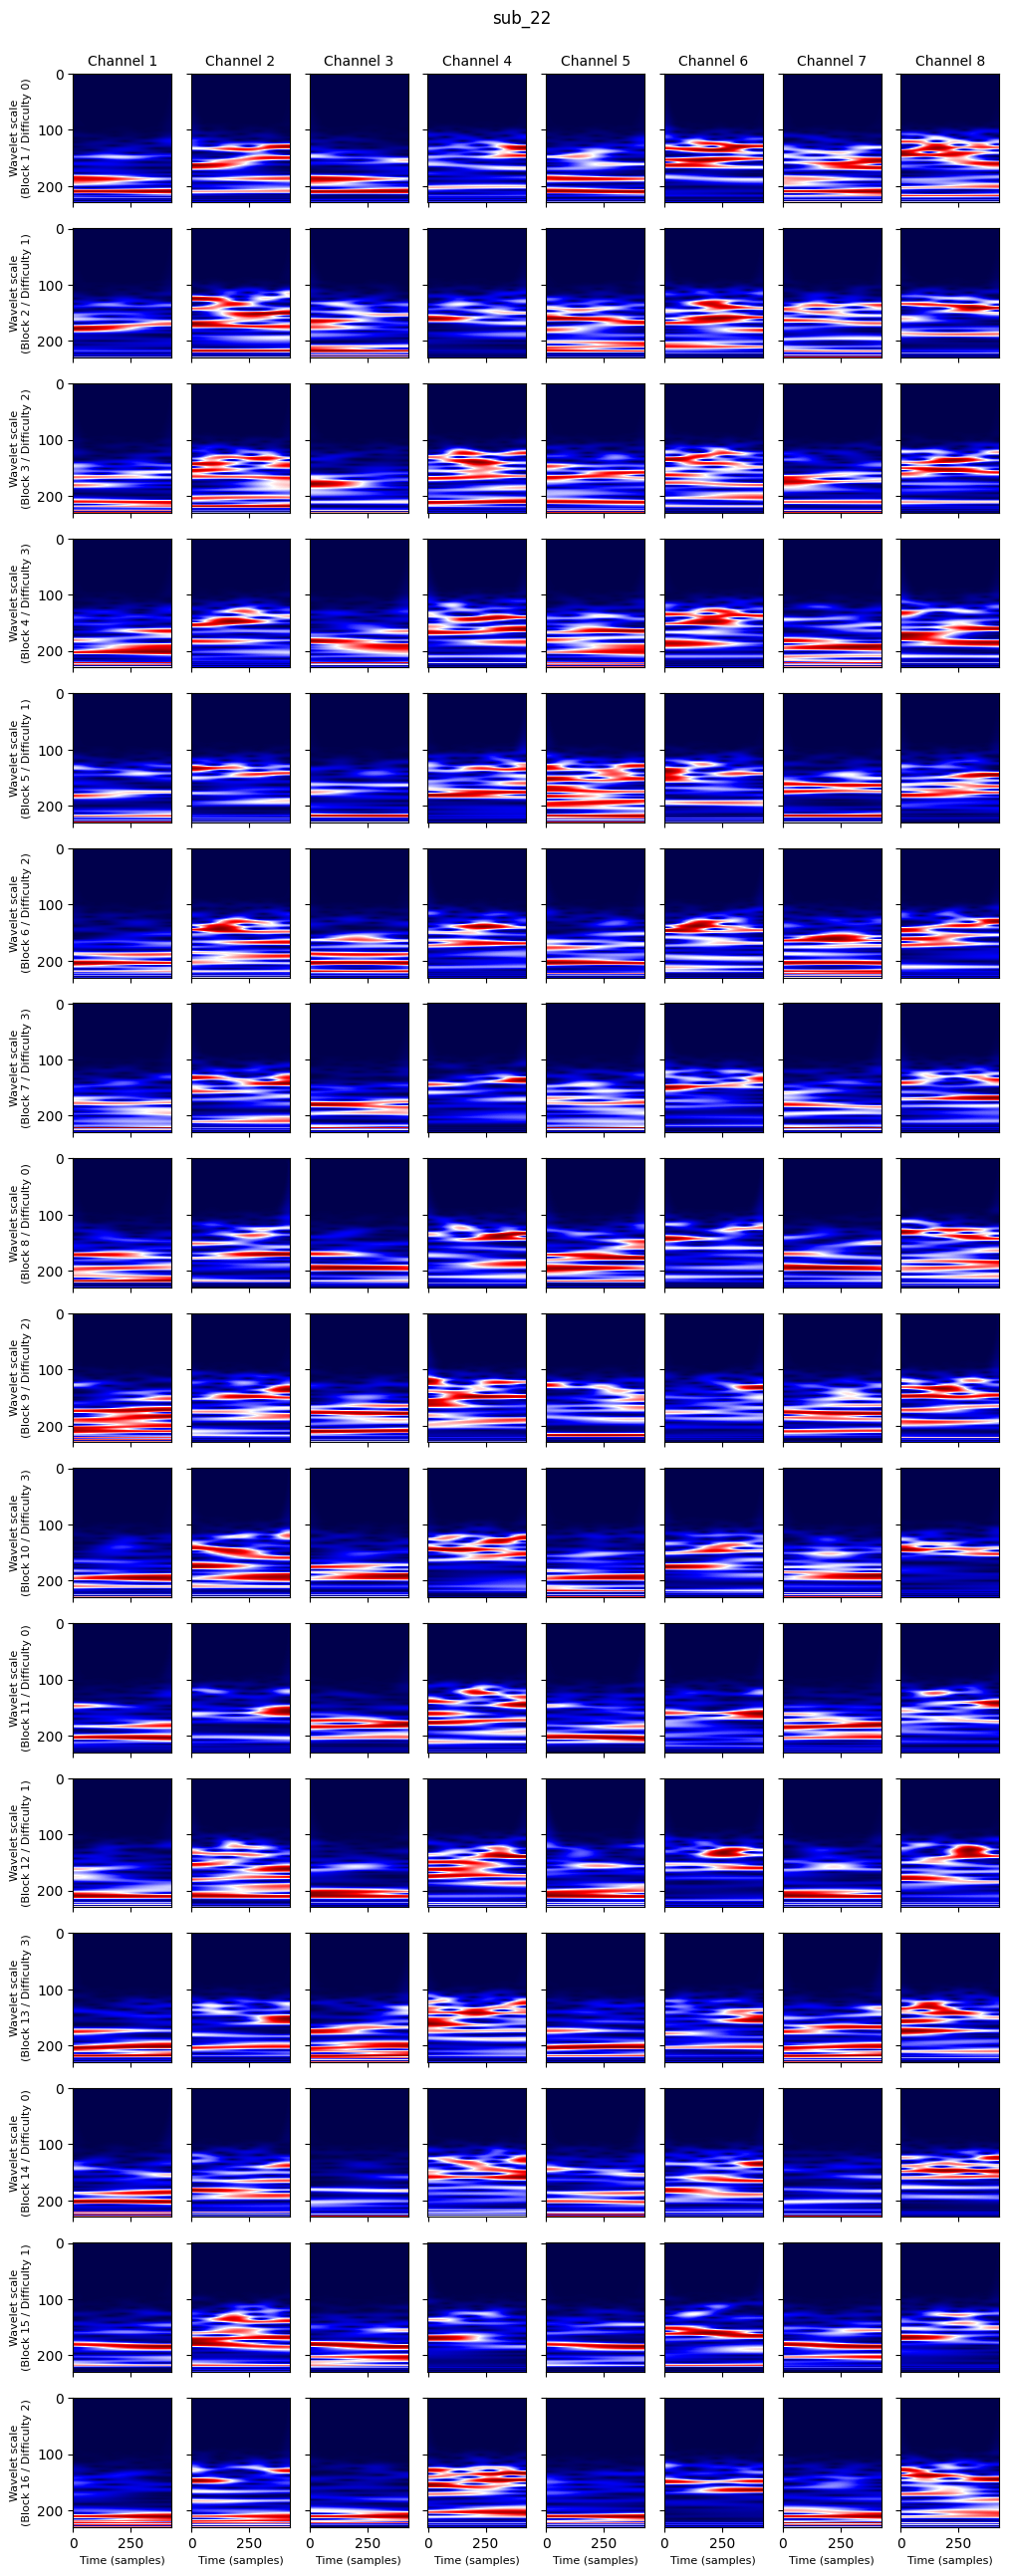

In [15]:
for f in [[x for x in os.listdir(scalogram_dir) if '.pt' in x][6]]:
    fig, ax = plt.subplots(nrows=16, ncols=8,
                           figsize=(12,32),
                           sharey=True, sharex=True)
    sub = ('_').join(f.split('_')[:2])
    fig.suptitle(sub, fontsize=12, y=0.9)
    sub_data = torch.load(os.path.join(scalogram_dir, f))
    sub_labels = np.load(os.path.join(scalogram_dir, f'{sub}_labels.npy'), allow_pickle=True).item()
    for row, (block_tensor) in enumerate(torch.unbind(sub_data, dim=0)):
        block = row+1
        for col, (channel_tensor) in enumerate(torch.unbind(block_tensor, dim=0)):
            sig = np.abs(channel_tensor.cpu().data.numpy()) #convert signal to numpy for plotting
            ax[row,col].imshow(sig, aspect='auto', cmap='seismic')
            ax[row,col].set_title(f'Channel {col+1}', fontsize=10) if row == 0 else None
            ax[row,col].set_ylabel(f'Wavelet scale\n(Block {block} / Difficulty {sub_labels[block]})', fontsize=8) if col == 0 else None
            ax[row,col].set_xlabel('Time (samples)', fontsize=8) if row == 15 else None
    break # just view one subject

In [110]:
# Assuming you have a tensor of shape [16, 8, 230, 426]
original_tensor = sub_data.abs()

# Specify the desired size of each split along the first dimension
desired_split_size = 60  # Adjust this based on your requirements

# Calculate the number of splits based on the original size and the desired size
num_splits = original_tensor.size(3) // desired_split_size

# Calculate the size of the last split
last_split_size = original_tensor.size(3) - (num_splits - 1) * desired_split_size

# Create a list to store split tensors
split_tensors = []
test_tensors = []

# Split the original tensor into desired-sized chunks
for i in range(num_splits):
    start_idx = i * desired_split_size
    end_idx = (i + 1) * desired_split_size
    
    if i > 1:
        split_tensors.append(original_tensor[:, :, :, start_idx:end_idx])
    else:
        test_tensors.append(original_tensor[:, :, :, start_idx:end_idx])
        
# Stack the split tensors along a new dimension
result_tensor = torch.stack(split_tensors, dim=1)
test_tensor = torch.stack(test_tensors, dim=1)

# Reshape the result tensor to merge the new dimension with the first dimension of the original tensor
result_tensor = result_tensor.view(-1, 8, 230, desired_split_size)
test_tensor = test_tensor.view(-1, 8, 230, desired_split_size)

# Print the shape of the resulting tensor
print(result_tensor.shape)
print(test_tensor.shape)

## Reshape labels to match splits ##
labels_list = list(np.array([[x]*(num_splits-2) for x in sub_labels.values()]).flatten())
test_labels = list(np.array([[x]*2 for x in sub_labels.values()]).flatten())

## Print shape of labels ##
print(len(labels_list))
print(len(test_labels))

torch.Size([80, 8, 230, 60])
torch.Size([32, 8, 230, 60])
80
32


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

class CustomMultiChannelModel(nn.Module):
    def __init__(self, num_channels, num_classes=4, chunk_size=60):
        super(CustomMultiChannelModel, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * (230 // 2 // 2) * (chunk_size // 2 // 2), 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.chunk_size = chunk_size
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * (230 // 2 // 2) * (self.chunk_size // 2 // 2))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Convert list of labels to a tensor and move it to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
labels_tensor = torch.tensor(labels_list).to(device)

# Create an instance of the CustomMultiChannelModel and move it to the same device as the labels
model = CustomMultiChannelModel(num_channels=8, num_classes=4, chunk_size=desired_split_size).to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Move the input tensor to the same device as the model
input_tensor = result_tensor.to(device)

# Convert 'input_tensor' and 'labels_tensor' to PyTorch DataLoader
dataset = TensorDataset(input_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=4, shuffle=True)  # Adjust batch size as needed

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

NameError: name 'labels_list' is not defined

In [117]:
dataset.tensors[0].shape

torch.Size([80, 8, 230, 60])

In [112]:
new_input_tensors = test_tensor.to(device)
new_labels_tensor = torch.tensor(test_labels).to(device)

model.eval()

correct_predictions = 0
total_instances = len(new_input_tensors)

with torch.no_grad():
    for new_input_tensor, label in zip(new_input_tensors, new_labels_tensor):
        # Make predictions
        predictions = model(new_input_tensor)

        # Convert the predictions to probabilities using softmax
        probabilities = F.softmax(predictions, dim=1)

        # Get the predicted class index
        predicted_class = torch.argmax(probabilities, dim=1).item()

        # Assuming you have ground truth labels for your instances
        # Adjust this part based on your actual labels
        ground_truth_label = label # Replace with the actual ground truth label
        if predicted_class == ground_truth_label:
            correct_predictions += 1

# Calculate average accuracy
average_accuracy = correct_predictions / total_instances

print("Average Accuracy:", average_accuracy)

Average Accuracy: 0.96875


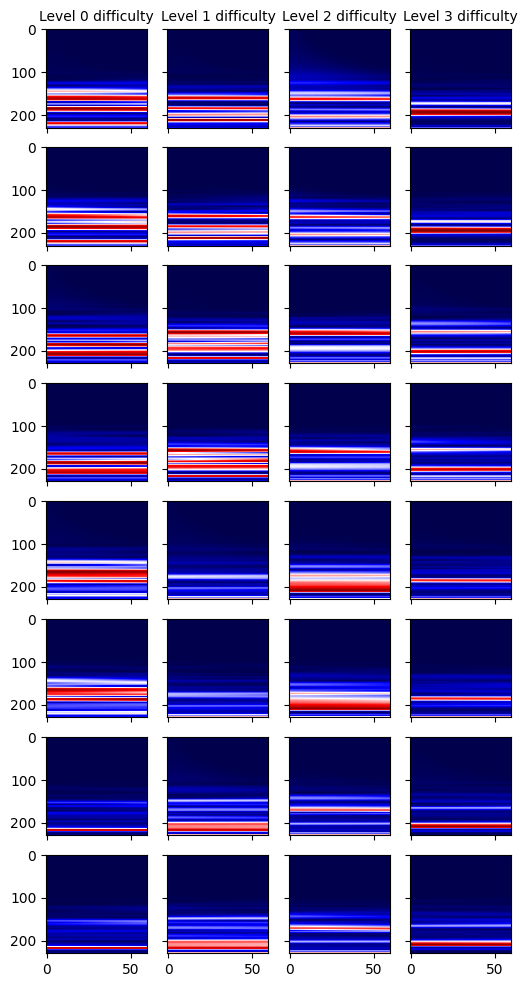

In [80]:
fig, ax= plt.subplots(nrows=8, ncols=4,
                      sharey=True, sharex=True,
                      figsize=(6,12))
rows = {0:0, 1:0, 2:0, 3:0}
for new_input_tensor, label in zip(torch.unbind(test_tensor, dim=0), test_labels):
    ax[rows[label], label].imshow(new_input_tensor[0].cpu().data.numpy(), aspect='auto', cmap='seismic')
    ax[rows[label], label].set_title(f'Level {label} difficulty', fontsize=10) if rows[label] == 0 else None
    rows[label] = rows[label] + 1